In [1]:
# Imports packages
import sys
import sys #reimport sys so we have it when not running package installation/setup
import infofile # local file containing cross-sections, sums of weights, dataset IDs
import numpy as np # for numerical calculations such as histogramming
import matplotlib.pyplot as plt # for plotting
import matplotlib_inline # to edit the inline plot format

#suspicious this is necessary, never had to do it before!
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg') # to make plots in pdf (vector) format

from matplotlib.ticker import AutoMinorLocator # for minor ticks
import uproot # for reading .root files
import awkward as ak # to represent nested data in columnar format
import vector # for 4-momentum calculations
import time
import pickle

In [2]:
# Creates a dictionary of all the data
samples = {
    'data': {
        'list' : ['data_A','data_B','data_C','data_D'], # data is from 2016, first four periods of data taking (ABCD)
    },
    'top':{ #processes with a top quark (single top, ttbar)
        'list' : ['ttbar_lep','single_top_tchan','single_antitop_tchan','single_top_wtchan','single_antitop_wtchan',
                  'single_top_schan','single_antitop_schan','ttW','ttee','ttmumu'],
        'color' : "#ffb255",
        'legend' : r'Top processes',
    },  
}

In [3]:
# Skims data
# Defines path to open data
path      = "https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/"
skim_name = "1lep"
value = samples['data']['list'][0] # Picks data from A-D

# Loads in data paths
data_A_path = path + skim_name + "/Data/" + value + "."+ skim_name + ".root"

# Loads in the data
tree = uproot.open(data_A_path + ":mini")
print(tree.keys())

['runNumber', 'eventNumber', 'channelNumber', 'mcWeight', 'scaleFactor_PILEUP', 'scaleFactor_ELE', 'scaleFactor_MUON', 'scaleFactor_PHOTON', 'scaleFactor_TAU', 'scaleFactor_BTAG', 'scaleFactor_LepTRIGGER', 'scaleFactor_PhotonTRIGGER', 'trigE', 'trigM', 'trigP', 'lep_n', 'lep_truthMatched', 'lep_trigMatched', 'lep_pt', 'lep_eta', 'lep_phi', 'lep_E', 'lep_z0', 'lep_charge', 'lep_type', 'lep_isTightID', 'lep_ptcone30', 'lep_etcone20', 'lep_trackd0pvunbiased', 'lep_tracksigd0pvunbiased', 'met_et', 'met_phi', 'jet_n', 'jet_pt', 'jet_eta', 'jet_phi', 'jet_E', 'jet_jvt', 'jet_trueflav', 'jet_truthMatched', 'jet_MV2c10', 'photon_n', 'photon_truthMatched', 'photon_trigMatched', 'photon_pt', 'photon_eta', 'photon_phi', 'photon_E', 'photon_isTightID', 'photon_ptcone30', 'photon_etcone20', 'photon_convType', 'tau_n', 'tau_pt', 'tau_eta', 'tau_phi', 'tau_E', 'tau_isTightID', 'tau_truthMatched', 'tau_trigMatched', 'tau_nTracks', 'tau_BDTid', 'ditau_m', 'lep_pt_syst', 'met_et_syst', 'jet_pt_syst', 'p

In [4]:
# Grabs the data for the jets
b_jet_selection = tree.arrays("jet_MV2c10", library="ak")["jet_MV2c10"]
jet_pt          = tree.arrays("jet_pt", library="ak")["jet_pt"]
jet_eta         = tree.arrays('jet_eta', library="ak")['jet_eta']
jet_E           = tree.arrays('jet_E', library="ak")['jet_E']
jet_phi         = tree.arrays("jet_phi", library="ak")["jet_phi"]

In [5]:
# Gets the data for the leptons
lep_type = tree.arrays("lep_type", library="ak")["lep_type"]
lep_pt   = tree.arrays("lep_pt", library="ak")["lep_pt"]
lep_eta  = tree.arrays("lep_eta", library="ak")["lep_eta"]
lep_phi  = tree.arrays("lep_phi", library="ak")["lep_phi"]
lep_E    = tree.arrays("lep_E", library="ak")["lep_E"]

In [6]:
# Gets the missing transverse energy
met_Et  = tree.arrays("met_et", library="ak")["met_et"]
met_phi = tree.arrays("met_phi", library="ak")["met_phi"]

(array([0.000000e+00, 0.000000e+00, 0.000000e+00, 3.573093e+06,
        3.335084e+06, 1.590558e+06, 5.368880e+05, 2.692920e+05,
        1.596680e+05, 9.778900e+04, 6.323500e+04, 4.293900e+04,
        2.980900e+04, 2.148400e+04, 1.570900e+04, 1.182500e+04,
        8.989000e+03, 7.111000e+03, 5.952000e+03, 4.616000e+03,
        3.721000e+03, 2.963000e+03, 2.411000e+03, 1.986000e+03]),
 array([  0.,   8.,  16.,  24.,  32.,  40.,  48.,  56.,  64.,  72.,  80.,
         88.,  96., 104., 112., 120., 128., 136., 144., 152., 160., 168.,
        176., 184., 192.]),
 <BarContainer object of 24 artists>)

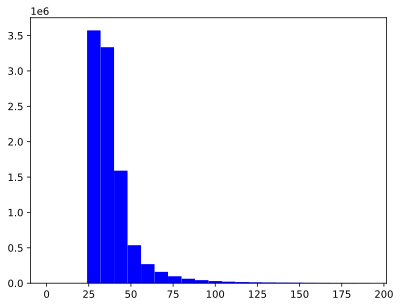

In [17]:
bins = np.arange(0,200,8)
fig,ax = plt.subplots()
ax.hist(lep_pt / 1e3, bins=bins, color='blue')

## Cuts

We start by cutting the data by imposing our jet cuts.
* Must have at least 2 jets
* One jet must be identified as a b-jet

In [92]:
# First look at what events actually have a b-jet present. Different cuts can be used to get different confidences, though at the cost of 
# removal of a number of events.
cut70 = 0.8244
cut77 = 0.6459
cut85 = 0.1758

# Generates the mask for events with exactly 2 jets
jet_mask = ak.num(jet_pt, axis=1) == 2

# Applies the mask to the jet data
b_jet_selection_cut = b_jet_selection[jet_mask]
jet_pt_cut          = jet_pt[jet_mask]
lep_type_cut        = lep_type[jet_mask]
lep_pt_cut          = lep_pt[jet_mask]
lep_eta_cut         = lep_eta[jet_mask]
jet_eta_cut         = jet_eta[jet_mask]
met_Et_cut          = met_Et[jet_mask]
lep_phi_cut         = lep_phi[jet_mask]
met_phi_cut         = met_phi[jet_mask]
lep_E_cut           = lep_E[jet_mask]
jet_E_cut           = jet_E[jet_mask]
jet_phi_cut         = jet_phi[jet_mask]

print(f'Length of data before 2-jet check {len(lep_pt):0.2e}')
print(f'Length of data after 2-jet check {len(lep_pt_cut):0.2e}')
print("")

#########################################################################################################
# Applies the jet selection to determine if a b-jet is present.
jet_mask2  = ak.Array(b_jet_selection_cut > cut77) # Determines where the value is above selection cut
jet_mask2  = ak.values_astype(jet_mask2, "int")    # sets the truth values to binary
jet_mask2  = ak.sum(jet_mask2, axis=1)             # Finds the events where there is a b-jet as determined from above
jet_mask2  = ak.where(jet_mask2 > 1, 0, jet_mask2) # Ensures there is only one jet
jet_mask2  = ak.values_astype(jet_mask2, "bool")   # Returns the value to a boolean

print(f'Length of data before b-jet discrimination {len(lep_pt_cut):0.2e}')
# Applies the mask on each of the data types
b_jet_selection_cut = b_jet_selection_cut[jet_mask2]
jet_pt_cut          = jet_pt_cut[jet_mask2]
lep_pt_cut          = lep_pt_cut[jet_mask2]
lep_eta_cut         = lep_eta_cut[jet_mask2]
jet_eta_cut         = jet_eta_cut[jet_mask2]
met_Et_cut          = met_Et_cut[jet_mask2]
lep_phi_cut         = lep_phi_cut[jet_mask2]
met_phi_cut         = met_phi_cut[jet_mask2]
lep_E_cut           = lep_E_cut[jet_mask2]
jet_E_cut           = jet_E_cut[jet_mask2]
jet_phi_cut         = jet_phi_cut[jet_mask2]

print(f'Length of data after b-jet discrimination {len(lep_pt_cut):0.2e}')
print("")

#########################################################################################################
# Sets up a cut such that the pseudorapidity of the untagged jet is greater than 1.5
eta_jet_thresh  = 1.5
b_jet_mask      = ak.Array(b_jet_selection_cut > cut77)

untagged_jets_eta = jet_eta_cut[~b_jet_mask]
keep_mask         = ak.all(untagged_jets_eta > eta_jet_thresh, axis=1)

print(f'Length of data before untagged jet eta cut {len(lep_pt_cut):0.2e}')
# Applies the mask to each data type
b_jet_selection_cut = b_jet_selection_cut[keep_mask]
jet_pt_cut          = jet_pt_cut[keep_mask]
lep_pt_cut          = lep_pt_cut[keep_mask]
lep_eta_cut         = lep_eta_cut[keep_mask]
jet_eta_cut         = jet_eta_cut[keep_mask]
met_Et_cut          = met_Et_cut[keep_mask]
lep_phi_cut         = lep_phi_cut[keep_mask]
met_phi_cut         = met_phi_cut[keep_mask]
lep_E_cut           = lep_E_cut[keep_mask]
jet_E_cut           = jet_E_cut[keep_mask]
jet_phi_cut         = jet_phi_cut[keep_mask]

print(f'Length of data after untagged jet eta cut {len(lep_pt_cut):0.2e}')
print("")

#########################################################################################################
# Sets up a cut such that the difference in pseudorapidity between any b-jets and untagged jets is > 1.5
eta_diff_thresh  = 1.5
b_jet_mask       = ak.Array(b_jet_selection_cut > cut77)

# Separate out the b-jets' eta and the untagged jets' eta
b_jets_eta        = jet_eta_cut[b_jet_mask]
untagged_jets_eta = jet_eta_cut[~b_jet_mask]

# Form all b-jet ↔ untagged-jet pairs for each event
pairs     = ak.cartesian([b_jets_eta, untagged_jets_eta], axis=1)
delta_eta = pairs["1"] - pairs["0"]

# Keep only events where *every* b-untagged pair has |eta_b - eta_u| > 1.5
keep_mask2 = ak.all(delta_eta > eta_diff_thresh, axis=1)

print(f'Length of data before jet eta diff cut {len(lep_pt_cut):0.2e}')
# Applies the event-level mask to each data array
b_jet_selection_cut = b_jet_selection_cut[keep_mask2]
jet_pt_cut          = jet_pt_cut[keep_mask2]
lep_pt_cut          = lep_pt_cut[keep_mask2]
lep_eta_cut         = lep_eta_cut[keep_mask2]
jet_eta_cut         = jet_eta_cut[keep_mask2]
met_Et_cut          = met_Et_cut[keep_mask2]
lep_phi_cut         = lep_phi_cut[keep_mask2]
met_phi_cut         = met_phi_cut[keep_mask2]
lep_E_cut           = lep_E_cut[keep_mask2]
jet_E_cut           = jet_E_cut[keep_mask2]
jet_phi_cut         = jet_phi_cut[keep_mask2]

print(f'Length of data after jet eta diff cut {len(lep_pt_cut):0.2e}')
print("")

#########################################################################################################
# Sets up a cut such that the minimum jet transverse momentum is greater than 30GeV
pt_jet_thresh  = 30 #GeV
pt_thresh_mask = (jet_pt_cut[:,0]*1e-3) > pt_jet_thresh

print(f'Length of data before b-jet pt cut {len(lep_pt_cut):0.2e}')
# Applies the mask to each data type
b_jet_selection_cut = b_jet_selection_cut[pt_thresh_mask]
jet_pt_cut          = jet_pt_cut[pt_thresh_mask]
lep_pt_cut          = lep_pt_cut[pt_thresh_mask]
lep_eta_cut         = lep_eta_cut[pt_thresh_mask]
jet_eta_cut         = jet_eta_cut[pt_thresh_mask]
met_Et_cut          = met_Et_cut[pt_thresh_mask]
lep_phi_cut         = lep_phi_cut[pt_thresh_mask]
met_phi_cut         = met_phi_cut[pt_thresh_mask]
lep_E_cut           = lep_E_cut[pt_thresh_mask]
jet_E_cut           = jet_E_cut[pt_thresh_mask]
jet_phi_cut         = jet_phi_cut[pt_thresh_mask]

print(f'Length of data after b-jet pt cut {len(lep_pt_cut):0.2e}')

Length of data before 2-jet check 9.80e+06
Length of data after 2-jet check 1.12e+06

Length of data before b-jet discrimination 1.12e+06
Length of data after b-jet discrimination 1.12e+05

Length of data before untagged jet eta cut 1.12e+05
Length of data after untagged jet eta cut 1.86e+04

Length of data before jet eta diff cut 1.86e+04
Length of data after jet eta diff cut 1.02e+04

Length of data before b-jet pt cut 1.02e+04
Length of data after b-jet pt cut 8.02e+03


In [93]:
# Cuts events with a transveres momentum of the lepton to be less than 35 GeV
lep_mom_cut = ak.Array((lep_pt_cut*1e-3) > 35)
lep_mom_cut = ak.values_astype(lep_mom_cut, "int")
lep_mom_cut = ak.sum(lep_mom_cut, axis=1)             
lep_mom_cut = ak.values_astype(lep_mom_cut, "bool")   # Returns the value to a boolean

print(f'Length of data before lepton momentum cut {len(lep_pt_cut):0.2e}')
# # Applies the mask to all the data
b_jet_selection_cut = b_jet_selection_cut[lep_mom_cut]
jet_pt_cut          = jet_pt_cut[lep_mom_cut]
lep_pt_cut          = lep_pt_cut[lep_mom_cut]
lep_eta_cut         = lep_eta_cut[lep_mom_cut]
jet_eta_cut         = jet_eta_cut[lep_mom_cut]
met_Et_cut          = met_Et_cut[lep_mom_cut]
lep_phi_cut         = lep_phi_cut[lep_mom_cut]
met_phi_cut         = met_phi_cut[lep_mom_cut]
lep_E_cut           = lep_E_cut[lep_mom_cut]
jet_E_cut           = jet_E_cut[lep_mom_cut]
jet_phi_cut         = jet_phi_cut[lep_mom_cut]

print(f'Length of data after lepton momentum cut {len(lep_pt_cut):0.2e}')

Length of data before lepton momentum cut 8.02e+03
Length of data after lepton momentum cut 3.64e+03


In [94]:
# Sets up the missing pt cut
miss_Et_cut_val  = 30 #GeV
miss_Et_cut_mask = ak.Array((met_Et_cut * 1e-3) > miss_Et_cut_val)

print(f'Length of data before missing energy cut {len(lep_pt_cut):0.2e}')
# # Applies the mask to all the data
b_jet_selection_cut = b_jet_selection_cut[miss_Et_cut_mask]
jet_pt_cut          = jet_pt_cut[miss_Et_cut_mask]
lep_pt_cut          = lep_pt_cut[miss_Et_cut_mask]
lep_eta_cut         = lep_eta_cut[miss_Et_cut_mask]
jet_eta_cut         = jet_eta_cut[miss_Et_cut_mask]
met_Et_cut          = met_Et_cut[miss_Et_cut_mask]
lep_phi_cut         = lep_phi_cut[miss_Et_cut_mask]
met_phi_cut         = met_phi_cut[miss_Et_cut_mask]
lep_E_cut           = lep_E_cut[miss_Et_cut_mask]
jet_E_cut           = jet_E_cut[miss_Et_cut_mask]
jet_phi_cut         = jet_phi_cut[miss_Et_cut_mask]

print(f'Length of data after missing energy cut {len(lep_pt_cut):0.2e}')

Length of data before missing energy cut 3.64e+03
Length of data after missing energy cut 1.95e+03


The next step is to calculate the transverse mass of the possible W-boson. From the definition,
$$
    (M_T^W)^2 = (E_{T1} + E_{T2})^2 + (p_{T1}+p_{T2})^2
$$
where subscript 1 represents the lepton in our data and 2 represents the missing energy. We can also define these values in terms of our data,

    E_{T1}  = lep_E_cut 
    E_{T2}  = met_Et_cut 
    p_{T1}  = (lep_pt_cut cos(lep_phi_cut)), lep_pt_cut sin(lep_phi_cut)))
    p_{T1}  = (sqrt(met_Et_cut) cos(met_phi_cut)), sqrt(met_Et_cut) sin(met_phi_cut)))

In [95]:
# calculates the momenta values to be used
pt1x = lep_pt_cut*np.cos(lep_phi_cut)
pt1y = lep_pt_cut*np.sin(lep_phi_cut)
pt2x = np.sqrt(met_Et_cut)*np.cos(met_phi_cut)
pt2y = np.sqrt(met_Et_cut)*np.sin(met_phi_cut)

# Adds the momentum components and computes the square
px = pt1x + pt2x
py = pt1y + pt2y
p_sq = px**2 + py**2

# Computes the energy term
E_sq = lep_E_cut**2 + met_Et_cut**2

# Computes the transverse mass
MtW = np.sqrt(E_sq + p_sq)

# APPLIES THE TRANSVERSE MASS CUT
mass_T_cut = 60 #GeV
mask7 = (MtW * 1e-3) > mass_T_cut
mask7 = mask7[:,0]

print(f'Length of data before missing energy cut {len(lep_pt_cut):0.2e}')
b_jet_selection_cut = b_jet_selection_cut[mask7]
jet_pt_cut          = jet_pt_cut[mask7]
lep_pt_cut          = lep_pt_cut[mask7]
lep_eta_cut         = lep_eta_cut[mask7]
jet_eta_cut         = jet_eta_cut[mask7]
met_Et_cut          = met_Et_cut[mask7]
lep_phi_cut         = lep_phi_cut[mask7]
met_phi_cut         = met_phi_cut[mask7]
lep_E_cut           = lep_E_cut[mask7]
jet_E_cut           = jet_E_cut[mask7]
jet_phi_cut         = jet_phi_cut[mask7]
MtW_cut             = MtW[mask7]

print(f'Length of data after missing energy cut {len(lep_pt_cut):0.2e}')

Length of data before missing energy cut 1.95e+03
Length of data after missing energy cut 1.95e+03


Note the last mask did not remove any elements as all elements that don't satisfy the mask have already been removed by other cuts.

We now move onto the scalar sum $H_T$. For our purposes, we define this as
$$
    H_T = + p_{T,jet1} + p_{T,jet2} + p_{T,lep} + E_{T,miss}
$$

In [96]:
# Calculates H_T
HT = ak.sum(jet_pt_cut, axis=1) + lep_pt_cut + met_Et_cut

# Applies the scalar sum cut
HT_min = 195 #GeV
mask8  = (HT * 1e-3) > HT_min 
mask8  = mask8[:,0]

print(f'Length of data before missing energy cut {len(lep_pt_cut):0.2e}')
b_jet_selection_cut = b_jet_selection_cut[mask8]
jet_pt_cut          = jet_pt_cut[mask8]
lep_pt_cut          = lep_pt_cut[mask8]
lep_eta_cut         = lep_eta_cut[mask8]
jet_eta_cut         = jet_eta_cut[mask8]
met_Et_cut          = met_Et_cut[mask8]
lep_phi_cut         = lep_phi_cut[mask8]
met_phi_cut         = met_phi_cut[mask8]
lep_E_cut           = lep_E_cut[mask8]
jet_E_cut           = jet_E_cut[mask8]
jet_phi_cut         = jet_phi_cut[mask8]
MtW_cut             = MtW_cut[mask8]
HT_cut              = HT[mask8]

print(f'Length of data after missing energy cut {len(lep_pt_cut):0.2e}')

Length of data before missing energy cut 1.95e+03
Length of data after missing energy cut 9.63e+02


Last, we compute $m_{lb}$ or
$$
    m_{lb} = \sqrt{(E_l+E_b)^2 - (p_l+p_b)^2}
$$
The momentum can be calculated from the transverse momentum and $\eta$ and $\phi$ via
\begin{align*}
    p_x & = p_t\cos\phi \\
    p_y & = p_t\sin\phi \\
    p_z & = p_t\sinh\eta \\
\end{align*}

In [99]:
# Generates a mask to only get the b tagged jet
b_jet_mask = ak.Array(b_jet_selection_cut > cut77)

# Computes the energy term
E_sq = (lep_E_cut + jet_E_cut[b_jet_mask])**2

# Computes the momentum term
# lepton
p1x = lep_pt_cut * np.cos(lep_phi_cut)
p1y = lep_pt_cut * np.sin(lep_phi_cut)
p1z = lep_pt_cut * np.sinh(lep_eta_cut)
# b-jet
p2x = jet_pt_cut[b_jet_mask] * np.cos(jet_phi_cut[b_jet_mask])
p2y = jet_pt_cut[b_jet_mask] * np.sin(jet_phi_cut[b_jet_mask])
p2z = jet_pt_cut[b_jet_mask] * np.sinh(jet_eta_cut[b_jet_mask])
# Adds the momentum together
p_totx = p1x + p2x
p_toty = p1y + p2y
p_totz = p1z + p2z
# Computes the square
p_sq = p_totx**2 + p_toty**2 + p_totz**2

# Computes the mass
m_lb = np.sqrt(E_sq + p_sq)

# Applies the cut for the mass
min_mass = 150 # GeV
mask9  = (m_lb * 1e-3) > min_mass
mask9  = mask9[:,0]

print(f'Length of data before missing energy cut {len(lep_pt_cut):0.2e}')
b_jet_selection_cut = b_jet_selection_cut[mask9]
jet_pt_cut          = jet_pt_cut[mask9]
lep_pt_cut          = lep_pt_cut[mask9]
lep_eta_cut         = lep_eta_cut[mask9]
jet_eta_cut         = jet_eta_cut[mask9]
met_Et_cut          = met_Et_cut[mask9]
lep_phi_cut         = lep_phi_cut[mask9]
met_phi_cut         = met_phi_cut[mask9]
lep_E_cut           = lep_E_cut[mask9]
jet_E_cut           = jet_E_cut[mask9]
jet_phi_cut         = jet_phi_cut[mask9]
MtW_cut             = MtW_cut[mask9]
HT_cut              = HT[mask9]
m_lb_cut            = m_lb[mask9]

print(f'Length of data after missing energy cut {len(lep_pt_cut):0.2e}')

Length of data before missing energy cut 8.60e+02
Length of data after missing energy cut 8.60e+02


In [98]:
# Saves the data to be called in a different notebook
with open("data.pkl", "wb") as f:
    pickle.dump([b_jet_selection_cut, jet_pt_cut, lep_pt_cut, lep_eta_cut, jet_eta_cut, met_Et_cut, lep_phi_cut, met_phi_cut, lep_E_cut, jet_E_cut, jet_phi_cut, MtW_cut, HT_cut, m_lb_cut], f)

Bins ranging from 0-200 GeV with a bin width of 18 GeV for a total of 12 bins


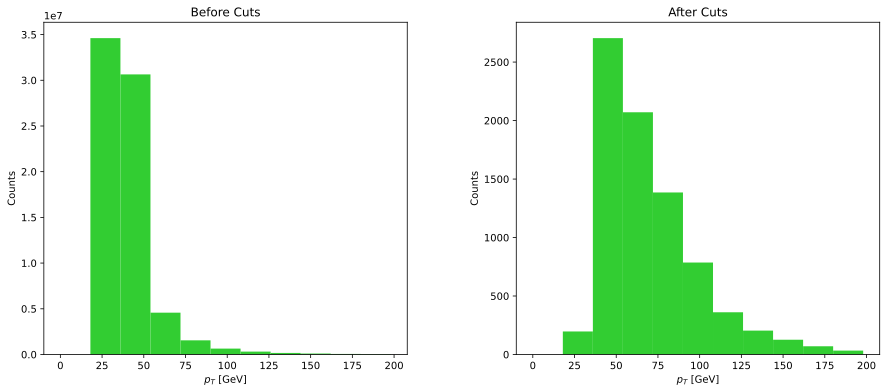

In [69]:
# Creates a plot of lepton transverse momentum before and after full cuts
bins = np.arange(0,200,18)
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,6))
plt.subplots_adjust(wspace=0.3) # Adjusts the space between the plots

# Before cuts
ax1.hist(lep_pt*1e-3, bins=bins, color='limegreen', label='Before Cuts')
ax1.set_xlabel(r'$p_T$ [GeV]')
ax1.set_ylabel('Counts')
ax1.set_title('Before Cuts')

# After cuts
ax2.hist(lep_pt_cut*1e-3, bins=bins, color='limegreen', label='After Cuts')
ax2.set_xlabel(r'$p_T$ [GeV]')
ax2.set_ylabel('Counts')
ax2.set_title('After Cuts')
print(f'Bins ranging from 0-200 GeV with a bin width of {np.diff(bins)[0]} GeV for a total of {len(bins)} bins')

Bins ranging from 0-200 GeV with a bin width of 12 GeV for a total of 25 bins


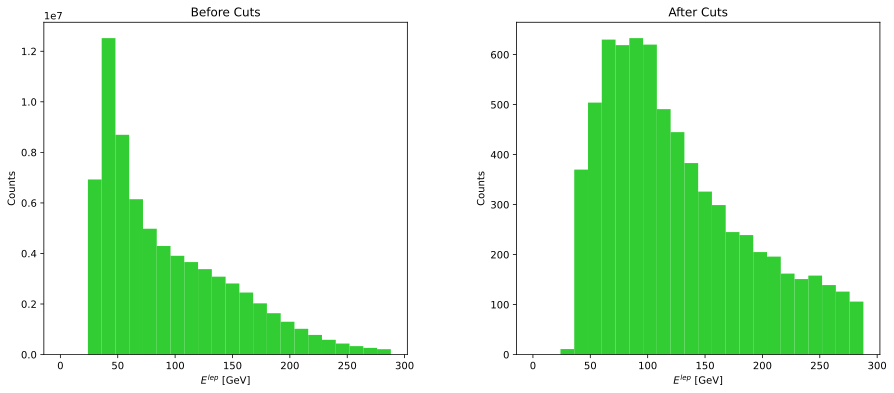

In [79]:
# Creates a plot of lepton energy before and after full cuts
bins = np.arange(0,300,12)
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,6))
plt.subplots_adjust(wspace=0.3) # Adjusts the space between the plots

# Before cuts
ax1.hist(lep_E*1e-3, bins=bins, color='limegreen', label='Before Cuts')
ax1.set_xlabel(r'$E^{lep}$ [GeV]')
ax1.set_ylabel('Counts')
ax1.set_title('Before Cuts')

# After cuts
ax2.hist(lep_E_cut*1e-3, bins=bins, color='limegreen', label='After Cuts')
ax2.set_xlabel(r'$E^{lep}$ [GeV]')
ax2.set_ylabel('Counts')
ax2.set_title('After Cuts')
print(f'Bins ranging from 0-200 GeV with a bin width of {np.diff(bins)[0]} GeV for a total of {len(bins)} bins')

Bins ranging from 0-200 GeV with a bin width of 18 GeV for a total of 12 bins


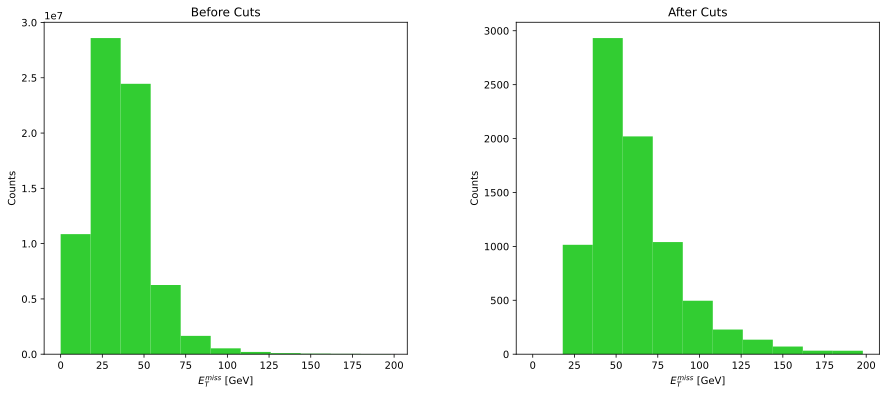

In [82]:
# Creates a plot of missing transverse energy before and after full cuts
bins = np.arange(0,200,18)
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,6))
plt.subplots_adjust(wspace=0.3) # Adjusts the space between the plots

# Before cuts
ax1.hist(met_Et*1e-3, bins=bins, color='limegreen', label='Before Cuts')
ax1.set_xlabel(r'$E^{miss}_T$ [GeV]')
ax1.set_ylabel('Counts')
ax1.set_title('Before Cuts')

# After cuts
ax2.hist(met_Et_cut*1e-3, bins=bins, color='limegreen', label='After Cuts')
ax2.set_xlabel(r'$E^{miss}_T$ [GeV]')
ax2.set_ylabel('Counts')
ax2.set_title('After Cuts')
print(f'Bins ranging from 0-200 GeV with a bin width of {np.diff(bins)[0]} GeV for a total of {len(bins)} bins')

In [83]:
len(lep_pt_cut)

8057